In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!ls 'drive/My Drive'
# 

In [ ]:
pip install scanpy

In [ ]:
pip install  sceb

In [1]:
import scanpy as sc

In [9]:
import sceb.scdd as sd

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import sceb.scdd as sd
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [22]:
def load_10x_4k():
    #filename_data = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/matrix.mtx'
    #filename_genes = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/genes.tsv'
    #filename_barcodes = '/data/martin/single_cell/10x_4k_PBMC/filtered_gene_bc_matrices/GRCh38/barcodes.tsv'

    filename_data = 'drive/My Drive/singlecell/matrix.mtx'
    filename_genes = 'drive/My Drive/singlecell/genes.tsv'
    filename_barcodes = 'drive/My Drive/singlecell/barcodes.tsv'

    data = sc.read(filename_data, cache=True).transpose()
    data.var_names = np.genfromtxt(filename_genes, dtype=str)[:, 1]
    data.smp_names = np.genfromtxt(filename_barcodes, dtype=str)
    return data
# Load the data.
data = load_10x_4k()
data.var_names_make_unique()
# Filter genes with >0.1 mean read per cell.
sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
gene_list = np.array(data.var_names)

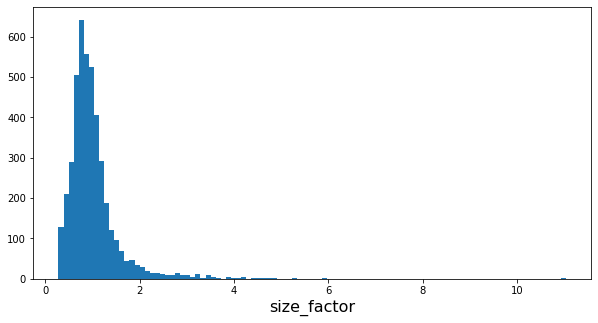

In [24]:
# Estimate the cell size factor
size_factor = sd.dd_size_factor(data)
plt.figure(figsize=[10,5])
plt.hist(size_factor, bins=100)
plt.xlabel('size_factor', fontsize=16)
plt.show()

In [25]:
M_ml, M_dd = sd.dd_1d_moment(data, size_factor=size_factor)
cv_ml = sd.M_to_cv(M_ml)
cv_dd = sd.M_to_cv(M_dd)

#time start: 0.0s
n_cell=4340, n_gene=4039
#total: 0.04s


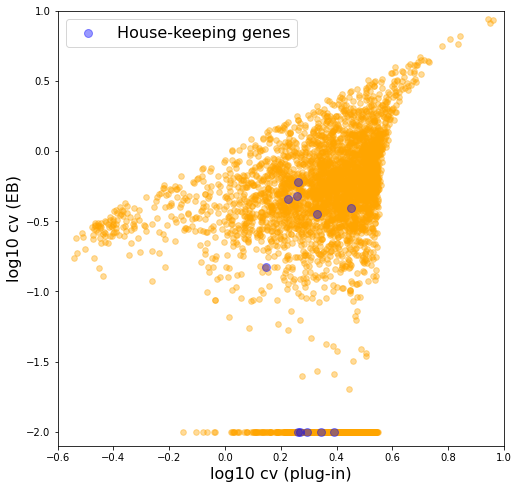

In [26]:
house_keeping_gene = np.array(['C1orf43', 'PSMB2', 'PSMB4', 'RAB7A', 'REEP5', 'VCP', 'VPS29',
                            'EMC7', 'GPI', 'CHMP2A', 'SNRPD3'], dtype=object)
ind_house_keeping = np.array([(gene in house_keeping_gene) for gene in gene_list])
# Log-scale.
log_10_cv_ml = np.log10(cv_ml)
log_10_cv_dd = np.log10(cv_dd)
# EB assigns a very small value (<1e-6) for genes which it thinks the cv is 0. Bring the 
# value of these genes back a bit for visualization purpose.
log_10_cv_dd[log_10_cv_dd<-2] = -2
# 
plt.figure(figsize=[8, 8])
plt.scatter(log_10_cv_ml, log_10_cv_dd, alpha=0.4, s=32, color='orange')
plt.scatter(log_10_cv_ml[ind_house_keeping], log_10_cv_dd[ind_house_keeping],\
            alpha=0.4, s=64, color='blue', label='House-keeping genes')
plt.xlabel('log10 cv (plug-in)', fontsize=16)
plt.ylabel('log10 cv (EB)', fontsize=16)
plt.legend(fontsize=16)
plt.xlim([-0.6, 1])
plt.ylim([-2.1, 1])
plt.show()

In [27]:
# Estimate PC using plug-in (ml)
mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data, size_factor=size_factor, verbose=True)
# Estimate PC using EB (dd)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data, size_factor=size_factor,\
                                         PC_prune=False, verbose=True)

#time start: 0.0s
n_cell=4340, n_gene=4039, Nr=4038.8
#total: 17.92s
#time start: 0.0s
n_cell=4340, n_gene=4039, Nr=4038.8
#total: 16.92s


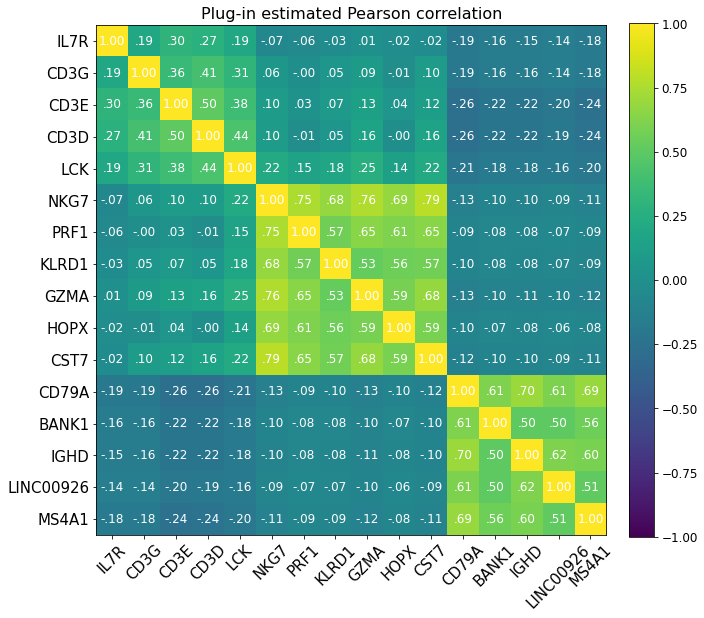

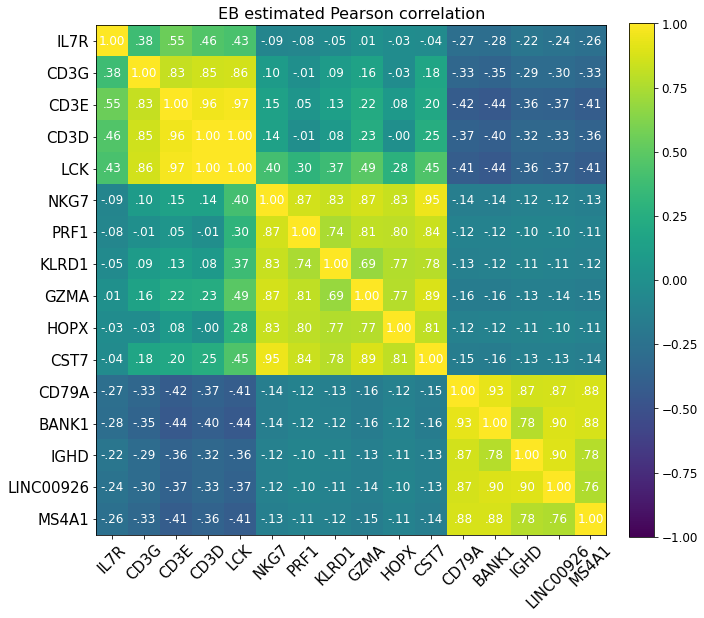

In [28]:
marker_gene_dic = {} 
marker_gene_dic['T-cells']= ['IL7R','CD3G','CD3E','CD3D','LCK']
marker_gene_dic['NK-cells']= ['NKG7','PRF1','KLRD1','GZMA','HOPX','CST7']
marker_gene_dic['B-cells']= ['CD79A','BANK1','IGHD','LINC00926','MS4A1']

# Plot for plug-in
plt.figure(figsize=[10, 10])
sd.marker_gene_heatmap(marker_gene_dic,gene_list,PC_ml)
plt.title('Plug-in estimated Pearson correlation', fontsize=16)
plt.show()

# Plot for EB 
plt.figure(figsize=[10, 10])
sd.marker_gene_heatmap(marker_gene_dic,gene_list,PC_dd)
plt.title('EB estimated Pearson correlation', fontsize=16)
plt.show()

In [29]:
from sklearn.decomposition import PCA
n_gene = 1000
# EB
ind_select = np.argsort(cv_dd)[-n_gene:]
temp = np.array(data[:, ind_select].X.todense())
temp = temp.clip(max=np.percentile(temp, 99))
PCA_dd = PCA()
PCA_dd.fit(temp)
PCA_score_dd = PCA_dd.transform(temp)
# Plug-in
ind_select = np.argsort(cv_ml)[-n_gene:]
temp = np.array(data[:, ind_select].X.todense())
temp = temp.clip(max=np.percentile(temp, 99))
PCA_ml = PCA()
PCA_ml.fit(temp)
PCA_score_ml = PCA_dd.transform(temp)

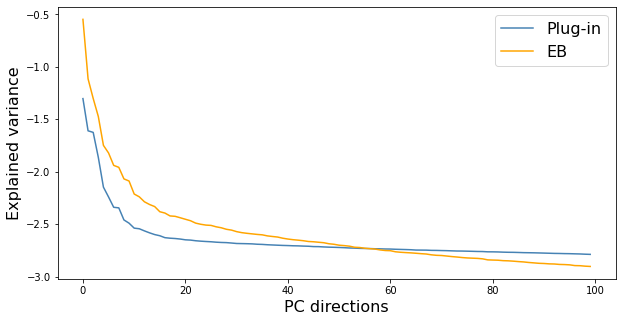

In [30]:
plt.figure(figsize=[10, 5])
plt.plot(np.log10(PCA_ml.explained_variance_ratio_[0:100]),
         color='steelblue', label='Plug-in')
plt.plot(np.log10(PCA_dd.explained_variance_ratio_[0:100]),
         color='orange', label='EB')
plt.legend(fontsize=16)
plt.xlabel('PC directions', fontsize=16)
plt.ylabel('Explained variance', fontsize=16)
plt.show()

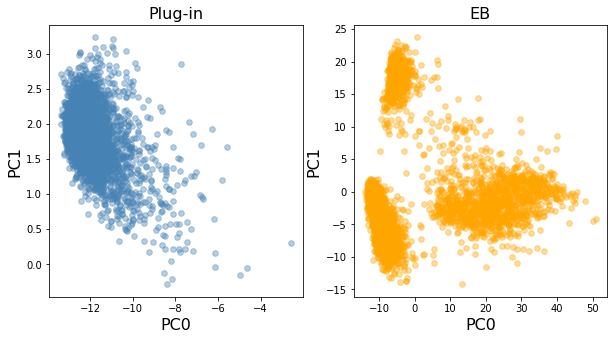

In [31]:
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.scatter(PCA_score_ml[:, 0], PCA_score_ml[:, 1], color='steelblue', s=32, alpha=0.4)
plt.xlabel('PC0', fontsize=16)
plt.ylabel('PC1', fontsize=16)
plt.title('Plug-in', fontsize=16)
plt.subplot(122)
plt.scatter(PCA_score_dd[:, 0], PCA_score_dd[:, 1], color='orange', s=32, alpha=0.4)
plt.xlabel('PC0', fontsize=16)
plt.ylabel('PC1', fontsize=16)
plt.title('EB', fontsize=16)
plt.show()